In [189]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [166]:
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r'<[^>]+>', ' ', s)           # quitar HTML
    s = re.sub(r'http\S+|www\.\S+', ' <URL> ', s)  # URLs -> token
    s = re.sub(r'\d{2,}', ' <NUM> ', s)     # números largos -> token
    s = re.sub(r'[^a-zA-Z0-9<> ]', ' ', s)  # quitar puntuación (simple)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

## get dataset

In [167]:
path_data = "dataset/spam.csv"
test_data = "dataset/spam_or_not_spam.csv"

In [168]:
df = pd.read_csv(path_data)
dt = pd.read_csv(test_data)

In [169]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [170]:
cols = dt.columns.str.lower()
if 'email' in cols:
    dt = dt.rename(columns={dt.columns[cols.tolist().index('email')]: 'message',})
else:
    # si no, inspecciona manualmente (muestra primeros 5 columnas)
    print("Revisa los nombres de columnas. Aquí un ejemplo:")
    display(df.head())

In [171]:
df["Category"].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [172]:
for label in df['Category'].unique():
    textos = df[df['Category'] == label]['Message'].astype(str)
    cv = CountVectorizer(stop_words='english', min_df=2)
    Xc = cv.fit_transform(textos)
    words = np.array(cv.get_feature_names_out())
    sums = Xc.toarray().sum(axis=0)
    top_idx = sums.argsort()[::-1][:20]
    print(f"Top palabras para '{label}':")
    print(words[top_idx])
    print()

Top palabras para 'ham':
['gt' 'lt' 'just' 'ok' 'll' 'ur' 'know' 'good' 'like' 'got' 'come' 'day'
 'love' 'time' 'going' 'want' 'home' 'lor' 'need' 'don']

Top palabras para 'spam':
['free' 'txt' 'ur' 'mobile' 'text' 'stop' 'claim' 'reply' 'www' 'prize'
 'just' 'cash' 'uk' 'won' '150p' 'send' 'new' 'nokia' 'win' 'urgent']



## transforming data

In [173]:
# ejemplo robusto: detectar columnas probables

cols = df.columns.str.lower()
if 'message' in cols and 'category' in cols:
    df = df.rename(columns={df.columns[cols.tolist().index('message')]: 'message',
                            df.columns[cols.tolist().index('category')]: 'label'})
else:
    # si no, inspecciona manualmente (muestra primeros 5 columnas)
    print("Revisa los nombres de columnas. Aquí un ejemplo:")
    display(df.head())

In [174]:
df['msg_len'] = df['message'].str.len()
print(df.groupby('label')['msg_len'].describe())

        count       mean        std  min    25%    50%    75%    max
label                                                               
ham    4825.0   71.44829  58.434864  2.0   33.0   52.0   93.0  910.0
spam    747.0  137.98929  29.980287  7.0  132.0  149.0  157.0  223.0


In [175]:
df['message_clean'] = df['message'].apply(clean_text)

In [176]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [177]:
test_x = dt['message'].apply(clean_text)
test_y = dt["label"]

In [178]:
X = df['message_clean']
y = df['label']

# stratify para mantener proporciones ham/spam
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

## MultinomialNB train

In [179]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)),
    ('clf', MultinomialNB(alpha=0.1))
])

In [180]:
param_grid = {
    'tfidf__ngram_range': [(1,1),(1,2)],
    'tfidf__min_df': [1,2,3],
    'clf__alpha': [0.01, 0.1, 0.5, 1.0]
}

gs = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
best = gs.best_estimator_
y_pred = best.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'clf__alpha': 0.1, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       1.00      0.93      0.96       149

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [181]:
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Confusion matrix:
 [[966   0]
 [ 11 138]]


In [184]:
y_pred = best.predict(test_x)

print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      2500
           1       0.52      0.13      0.21       500

    accuracy                           0.83      3000
   macro avg       0.68      0.55      0.56      3000
weighted avg       0.79      0.83      0.79      3000



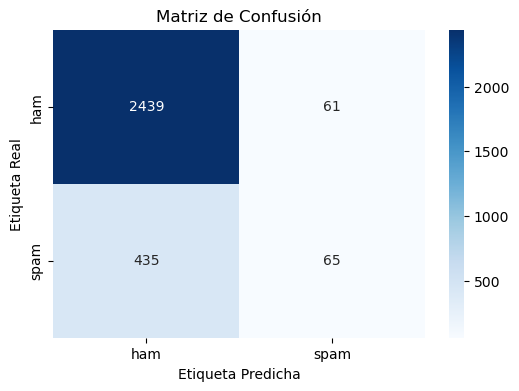

In [190]:
cm = confusion_matrix(test_y, y_pred)
labels = ['ham', 'spam']

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión')
plt.show()

In [208]:
test_y

0       0
1       0
2       0
3       0
4       0
       ..
2995    1
2996    1
2997    1
2998    1
2999    1
Name: label, Length: 3000, dtype: int64

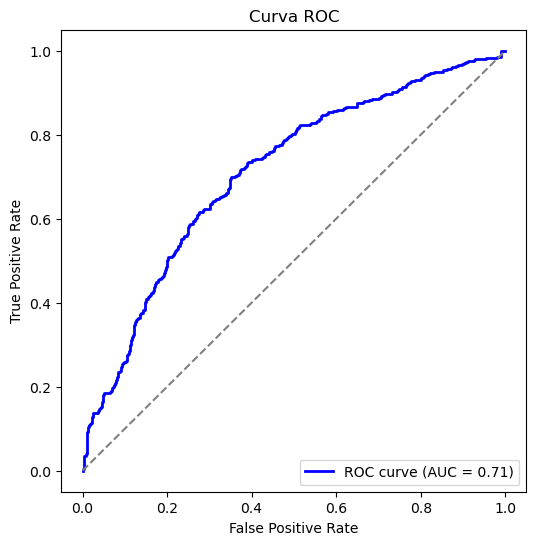

In [209]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

#
y_prob = best.predict_proba(test_x)[:, 1]  

# Calcular puntos de la curva ROC
fpr, tpr, thresholds = roc_curve(test_y, y_prob)

# Calcular AUC (Area Under Curve)
roc_auc = roc_auc_score(test_y, y_prob)

# Graficar
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # línea aleatoria
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [65]:
best.named_steps

{'tfidf': TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2)),
 'clf': MultinomialNB(alpha=0.1)}

## Suport Vector Machine

In [191]:
pipeline_SVM = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC(max_iter=5000))
])

In [192]:
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [1, 2, 3],
    'tfidf__max_df': [0.9, 0.95, 1.0],
    'tfidf__stop_words': [None, 'english'],
    'clf__C': [0.01, 0.1, 1, 10]
}


In [193]:
gs = GridSearchCV(pipeline_SVM, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=2)
gs.fit(X_train, y_train)

print("Mejores parámetros:", gs.best_params_)
print("Mejor score:", gs.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Mejores parámetros: {'clf__C': 10, 'tfidf__max_df': 0.9, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}
Mejor score: 0.9891000114179773
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       966
           1       0.99      0.95      0.97       149

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [195]:
y_pred = gs.predict(test_x)
from sklearn.metrics import classification_report
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.68      0.77      2500
           1       0.28      0.61      0.38       500

    accuracy                           0.67      3000
   macro avg       0.59      0.65      0.58      3000
weighted avg       0.79      0.67      0.71      3000



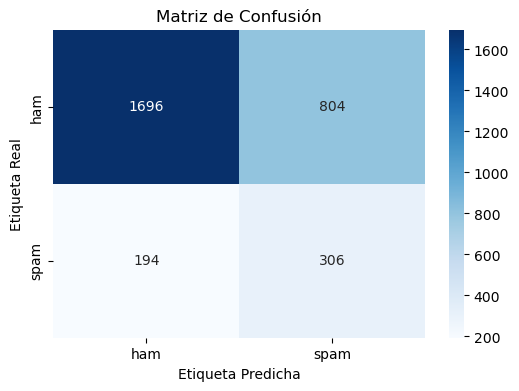

In [196]:
cm = confusion_matrix(test_y, y_pred)
labels = ['ham', 'spam']

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión')
plt.show()

In [197]:
y_pred = gs.predict(test_x)

print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.68      0.77      2500
           1       0.28      0.61      0.38       500

    accuracy                           0.67      3000
   macro avg       0.59      0.65      0.58      3000
weighted avg       0.79      0.67      0.71      3000



## individual test

In [91]:
spam_messages = [
    "Congratulations! You've won a $1,000 Walmart gift card. Click here to claim now.",
    "Urgent! Your account has been compromised. Reset your password immediately at http://fakebank.com/reset",
    "You have been selected for a free cruise to the Bahamas! Call 1-800-123-4567 now.",
    "Earn $5000 a week from home. No experience required. Sign up today at www.easycash.com",
    "Get cheap meds without prescription! Visit http://cheapmeds.example.com and save big.",
    "Limited time offer! Buy one, get one free on all products. Visit www.shopnow.com",
    "Act now! Last chance to secure your loan with low interest rates. Apply at www.quickloan.com",
    "Work from home and make $1000 per day! Click here to start.",
    "Your package is waiting for you. Confirm your address at http://tracking.fakeurl.com",
    "Lowest prices on electronics! Visit www.dealsnow.com",
    "Hot singles in your area are waiting to meet you! Join now!",
    "Get a new credit card with zero interest. Apply today!",
    "This is not a scam! Claim your inheritance now by calling 1-800-000-0000",
    "Congratulations! You won a free iPhone. Click here to claim.",
    "Make money fast with this simple trick. Visit www.easymoney.com",
    "Save big on your car insurance. Get a free quote now.",
    "Exclusive offer for you! Buy our product and get 50% off.",
    "Your computer is infected! Download our free antivirus now.",
    "Earn extra income without leaving your house. Sign up now!",
    "You have a new voicemail. Listen now at http://voicemail.fakeurl.com",
    # 20
    "Become a millionaire in 30 days! Start now.",
    "Claim your free trial today. No credit card required.",
    "Get your diploma online without studying! Click here.",
    "Unlock your phone for free. Visit www.unlocknow.com",
    "Cheap prescription drugs available now! Order today.",
    "Win big prizes with our lottery. Enter now.",
    "Act fast! Limited spots available for this offer.",
    "Make your ex jealous with this simple method.",
    "New weight loss pill that really works. Buy now.",
    "Your loan has been approved. Click here to get funds.",
    # 30
    "Invest in crypto and double your money quickly.",
    "You have an unpaid invoice. Pay immediately to avoid penalties.",
    "Get free gift cards by completing surveys.",
    "Hot deals on luxury watches. Limited time only.",
    "Claim your cash reward before it's gone.",
    "Your account will be suspended unless verified now.",
    "Special discount on all your favorite brands.",
    "Earn money playing games online. Join free today.",
    "Congratulations! You're pre-approved for a credit increase.",
    "New miracle cream for flawless skin. Order now.",
    # 40
    "Your tax refund is ready. Submit your details.",
    "Exclusive membership offer. Join today and save.",
    "Work at home and earn thousands monthly.",
    "Limited time: Free shipping on all orders.",
    "Claim your prize by clicking the link.",
    "You won a free vacation package. Act now!",
    "Get your free credit report instantly.",
    "Buy now and get an extra gift for free.",
    "Your device warranty has expired. Renew now.",
    "Make money fast with this secret method.",
    # 50
    "Get paid to watch videos online.",
    "Lose weight without dieting. Try our product.",
    "You are selected for a special bonus. Claim now.",
    "New software can make you rich overnight.",
    "Your package delivery failed. Reschedule now.",
    "Get a personal loan with low interest rates.",
    "Earn passive income from home easily.",
    "Limited offer: Save 70% on all electronics.",
    "Exclusive deals for new customers only.",
    "Win a free tablet by entering the contest.",
    # 60
    "Your bank account is at risk. Verify immediately.",
    "Make $1000 per day working online.",
    "Free membership for a limited time.",
    "Click here to unlock exclusive content.",
    "You have won a brand new car!",
    "Get rid of bad credit fast. Apply now.",
    "Hot singles want to chat with you now!",
    "Special promotion ends today. Don't miss out.",
    "Make money with no investment required.",
    "Your social security number has been compromised.",
    # 70
    "Download free music and movies here.",
    "Act now to receive your bonus gift card.",
    "This offer expires soon. Claim yours today.",
    "Join millions earning money from home.",
    "New breakthrough pill guarantees weight loss.",
    "Congratulations! You qualify for a free gift.",
    "Your loan application has been approved.",
    "Get cash advances with no credit check.",
    "Limited time offer: Get 2 for the price of 1.",
    "Claim your free samples now.",
    # 80
    "Earn cash fast with our affiliate program.",
    "Your account is locked due to suspicious activity.",
    "Get paid for your opinions. Sign up today.",
    "Special discount for loyal customers.",
    "Win big with our online casino. Play now.",
    "Make money without leaving your home.",
    "Congratulations! You have a pending refund.",
    "Exclusive access to premium content. Subscribe now.",
    "Get rich quick with this amazing opportunity.",
    "Your subscription has been renewed successfully.",
    # 90
    "Work from home jobs available now.",
    "Get free tickets to concerts and events.",
    "New credit card offers just for you.",
    "Download our app to save money instantly.",
    "Make money trading stocks easily.",
    "Claim your prize before time runs out.",
    "Get a refund for your last purchase.",
    "Your email has been selected for a prize.",
    "Free entry to sweepstakes. Enter today.",
    "Limited offer: Upgrade your account now."
]


In [158]:
predicciones = []
for i in spam_messages:
    clean_work = clean_text(i)
    # El método predict espera una lista o array de textos
    prediccion = best.predict([clean_work])
    predicciones.append( prediccion[0])


In [159]:
spam_count

41

In [188]:
total = len(predicciones)
spam_count = predicciones.count(0)
result = spam_count / total

print(result)


0.59
